**Домашнее задание №2** - Латентное пространство в VAE автоенкодере

Прочитайте внимательно статью "Variational Autoencoders are Beautiful":

https://www.compthree.com/blog/autoencoder/

В данном задании необходимо:

1) реализовать VAE автоенкодер с архитектурой как на рисунке:
<img src='mnist_vae.png' width=500>

2) Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_cloud.png' width=500>

3) Наконец, построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_digits.png' width=500>

Для реализации VAE автоенкодера воспользуйтесь кодом ниже:

In [7]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 500
h1_dim = 250
z_dim = 2
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=500, h1_dim=250, z_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, h1_dim)
        self.fc3 = nn.Linear(h1_dim, z_dim)
        self.fc4 = nn.Linear(h1_dim, z_dim)
        self.fc5 = nn.Linear(z_dim, h1_dim)
        self.fc6 = nn.Linear(h1_dim, h_dim)
        self.fc7 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h), self.fc4(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        return F.sigmoid(self.fc7(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/15], Step [10/469], Reconst Loss: 33457.2500, KL Div: 1572.1635
Epoch[1/15], Step [20/469], Reconst Loss: 27698.5684, KL Div: 224.4875
Epoch[1/15], Step [30/469], Reconst Loss: 26708.8496, KL Div: 130.2067
Epoch[1/15], Step [40/469], Reconst Loss: 27042.4707, KL Div: 220.4513
Epoch[1/15], Step [50/469], Reconst Loss: 25523.7578, KL Div: 361.6801
Epoch[1/15], Step [60/469], Reconst Loss: 25382.5156, KL Div: 307.4214
Epoch[1/15], Step [70/469], Reconst Loss: 25233.0508, KL Div: 295.9048
Epoch[1/15], Step [80/469], Reconst Loss: 24364.4336, KL Div: 327.3165
Epoch[1/15], Step [90/469], Reconst Loss: 24157.7852, KL Div: 307.9960
Epoch[1/15], Step [100/469], Reconst Loss: 24142.6191, KL Div: 310.9301
Epoch[1/15], Step [110/469], Reconst Loss: 23580.2539, KL Div: 284.4264
Epoch[1/15], Step [120/469], Reconst Loss: 23567.5977, KL Div: 350.3109
Epoch[1/15], Step [130/469], Reconst Loss: 23687.8887, KL Div: 337.7367
Epoch[1/15], Step [140/469], Reconst Loss: 23567.0391, KL Div: 448.8549


Epoch[3/15], Step [240/469], Reconst Loss: 19343.5820, KL Div: 717.2782
Epoch[3/15], Step [250/469], Reconst Loss: 19104.6562, KL Div: 762.0439
Epoch[3/15], Step [260/469], Reconst Loss: 19187.4238, KL Div: 723.7755
Epoch[3/15], Step [270/469], Reconst Loss: 18648.5254, KL Div: 723.9125
Epoch[3/15], Step [280/469], Reconst Loss: 18282.2695, KL Div: 749.4107
Epoch[3/15], Step [290/469], Reconst Loss: 18636.0938, KL Div: 728.2012
Epoch[3/15], Step [300/469], Reconst Loss: 19108.7930, KL Div: 716.0300
Epoch[3/15], Step [310/469], Reconst Loss: 19263.3066, KL Div: 693.4578
Epoch[3/15], Step [320/469], Reconst Loss: 18305.6836, KL Div: 748.9712
Epoch[3/15], Step [330/469], Reconst Loss: 18663.0703, KL Div: 732.0281
Epoch[3/15], Step [340/469], Reconst Loss: 18162.5996, KL Div: 725.3513
Epoch[3/15], Step [350/469], Reconst Loss: 18490.1367, KL Div: 750.4698
Epoch[3/15], Step [360/469], Reconst Loss: 18721.6914, KL Div: 752.2267
Epoch[3/15], Step [370/469], Reconst Loss: 18960.8770, KL Div: 7

Epoch[6/15], Step [10/469], Reconst Loss: 18126.4727, KL Div: 819.0100
Epoch[6/15], Step [20/469], Reconst Loss: 18309.8867, KL Div: 765.7377
Epoch[6/15], Step [30/469], Reconst Loss: 17701.0254, KL Div: 786.0588
Epoch[6/15], Step [40/469], Reconst Loss: 19256.7969, KL Div: 771.9285
Epoch[6/15], Step [50/469], Reconst Loss: 17860.3145, KL Div: 845.1564
Epoch[6/15], Step [60/469], Reconst Loss: 17189.5664, KL Div: 799.6999
Epoch[6/15], Step [70/469], Reconst Loss: 17903.6172, KL Div: 816.3663
Epoch[6/15], Step [80/469], Reconst Loss: 18268.0352, KL Div: 771.9059
Epoch[6/15], Step [90/469], Reconst Loss: 17527.2930, KL Div: 807.0681
Epoch[6/15], Step [100/469], Reconst Loss: 18798.8633, KL Div: 807.5673
Epoch[6/15], Step [110/469], Reconst Loss: 17080.4531, KL Div: 780.5959
Epoch[6/15], Step [120/469], Reconst Loss: 18041.1836, KL Div: 764.0592
Epoch[6/15], Step [130/469], Reconst Loss: 18580.4023, KL Div: 804.5649
Epoch[6/15], Step [140/469], Reconst Loss: 16791.5449, KL Div: 807.8541
E

Epoch[8/15], Step [240/469], Reconst Loss: 18315.1191, KL Div: 820.1746
Epoch[8/15], Step [250/469], Reconst Loss: 16634.5254, KL Div: 832.1714
Epoch[8/15], Step [260/469], Reconst Loss: 17882.6855, KL Div: 830.6661
Epoch[8/15], Step [270/469], Reconst Loss: 16883.6914, KL Div: 803.2266
Epoch[8/15], Step [280/469], Reconst Loss: 17570.5039, KL Div: 808.9429
Epoch[8/15], Step [290/469], Reconst Loss: 17375.8594, KL Div: 838.9945
Epoch[8/15], Step [300/469], Reconst Loss: 17015.0977, KL Div: 800.1066
Epoch[8/15], Step [310/469], Reconst Loss: 17599.1250, KL Div: 828.6729
Epoch[8/15], Step [320/469], Reconst Loss: 17237.2129, KL Div: 830.2705
Epoch[8/15], Step [330/469], Reconst Loss: 17739.5781, KL Div: 834.0928
Epoch[8/15], Step [340/469], Reconst Loss: 17195.6602, KL Div: 800.5656
Epoch[8/15], Step [350/469], Reconst Loss: 17239.6602, KL Div: 838.8937
Epoch[8/15], Step [360/469], Reconst Loss: 17746.8164, KL Div: 823.3530
Epoch[8/15], Step [370/469], Reconst Loss: 18030.0684, KL Div: 8

Epoch[10/15], Step [460/469], Reconst Loss: 17098.8594, KL Div: 830.5493
Epoch[11/15], Step [10/469], Reconst Loss: 17831.5742, KL Div: 799.4434
Epoch[11/15], Step [20/469], Reconst Loss: 18194.9219, KL Div: 836.4869
Epoch[11/15], Step [30/469], Reconst Loss: 17181.7070, KL Div: 830.7905
Epoch[11/15], Step [40/469], Reconst Loss: 17942.2207, KL Div: 830.7763
Epoch[11/15], Step [50/469], Reconst Loss: 17092.9824, KL Div: 857.4193
Epoch[11/15], Step [60/469], Reconst Loss: 17350.1406, KL Div: 855.0184
Epoch[11/15], Step [70/469], Reconst Loss: 16649.5586, KL Div: 788.6072
Epoch[11/15], Step [80/469], Reconst Loss: 17982.1035, KL Div: 833.2873
Epoch[11/15], Step [90/469], Reconst Loss: 17449.0918, KL Div: 845.1815
Epoch[11/15], Step [100/469], Reconst Loss: 17101.8789, KL Div: 840.2982
Epoch[11/15], Step [110/469], Reconst Loss: 16639.2012, KL Div: 868.7676
Epoch[11/15], Step [120/469], Reconst Loss: 18338.3223, KL Div: 831.5607
Epoch[11/15], Step [130/469], Reconst Loss: 17337.8438, KL D

Epoch[13/15], Step [210/469], Reconst Loss: 17477.6133, KL Div: 924.2955
Epoch[13/15], Step [220/469], Reconst Loss: 17568.6602, KL Div: 858.5538
Epoch[13/15], Step [230/469], Reconst Loss: 17279.7246, KL Div: 870.3479
Epoch[13/15], Step [240/469], Reconst Loss: 17992.7734, KL Div: 853.0732
Epoch[13/15], Step [250/469], Reconst Loss: 17447.5684, KL Div: 839.5057
Epoch[13/15], Step [260/469], Reconst Loss: 17040.8047, KL Div: 874.4090
Epoch[13/15], Step [270/469], Reconst Loss: 17067.0410, KL Div: 855.5548
Epoch[13/15], Step [280/469], Reconst Loss: 17922.0957, KL Div: 836.8341
Epoch[13/15], Step [290/469], Reconst Loss: 17490.7988, KL Div: 851.3787
Epoch[13/15], Step [300/469], Reconst Loss: 17152.0898, KL Div: 826.9299
Epoch[13/15], Step [310/469], Reconst Loss: 16524.3203, KL Div: 851.9897
Epoch[13/15], Step [320/469], Reconst Loss: 17508.0664, KL Div: 825.5198
Epoch[13/15], Step [330/469], Reconst Loss: 15857.7461, KL Div: 852.0750
Epoch[13/15], Step [340/469], Reconst Loss: 16808.0

Epoch[15/15], Step [420/469], Reconst Loss: 16837.2188, KL Div: 861.3503
Epoch[15/15], Step [430/469], Reconst Loss: 16781.7188, KL Div: 845.1008
Epoch[15/15], Step [440/469], Reconst Loss: 16494.4023, KL Div: 863.2896
Epoch[15/15], Step [450/469], Reconst Loss: 16851.8457, KL Div: 882.9250
Epoch[15/15], Step [460/469], Reconst Loss: 15802.4795, KL Div: 856.5243


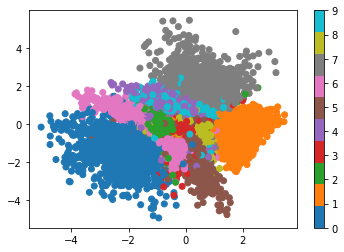

In [13]:
import matplotlib.pyplot as plt

new_data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                             batch_size = 128,
                                             shuffle = True)

for i, (x, y) in enumerate(new_data_loader):
    x = x.view(-1, image_size)
    t = model.reparameterize(model.encode(x.to(device))[0], model.encode(x.to(device))[1])
    t = t.to(device).detach().numpy()
    plt.scatter(t[:, 0], t[:, 1], c=y, cmap='tab10')
    if i > batch_size:
        plt.colorbar()
        break
    

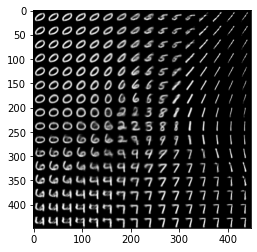

In [15]:
values = np.arange(-4, 4, .5)
xx, yy = np.meshgrid(values, values)
point = np.zeros((1, 2))
container = np.zeros((28 * len(values), 28 * len(values)))

test_data_loader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True)

for row in range(xx.shape[0]):
    for col in range(xx.shape[1]):
        point[0, :] = [xx[row, col], yy[row, col]]
        #print(type(input_holder))
        #torch.from_numpy(input_holder[0, : ])
        model.decode(torch.from_numpy(point[0, :]).float())
        new_image = model.decode(torch.from_numpy(point[0, :]).float())
        new_image = new_image.detach().numpy()
        container[row * 28: (row + 1) * 28, col * 28: (col + 1) * 28] = np.reshape(new_image, (28, 28))
plt.imshow(container, cmap='gray')